### Evaluation of visual similarity between the Figma prototypes and web UIs from the generated Vue code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join

In [2]:
generatedFolder = "/home/joao/figma2vuejs/evaluation/generated/"
prototypesFolder = "/home/joao/figma2vuejs/evaluation/prototype/"

generatedFiles = [generatedFolder+f for f in listdir(generatedFolder) if isfile(join(generatedFolder, f))]
prototypeFiles = [prototypesFolder+f for f in listdir(prototypesFolder) if isfile(join(prototypesFolder, f))]

generatedFiles.sort()
prototypeFiles.sort()

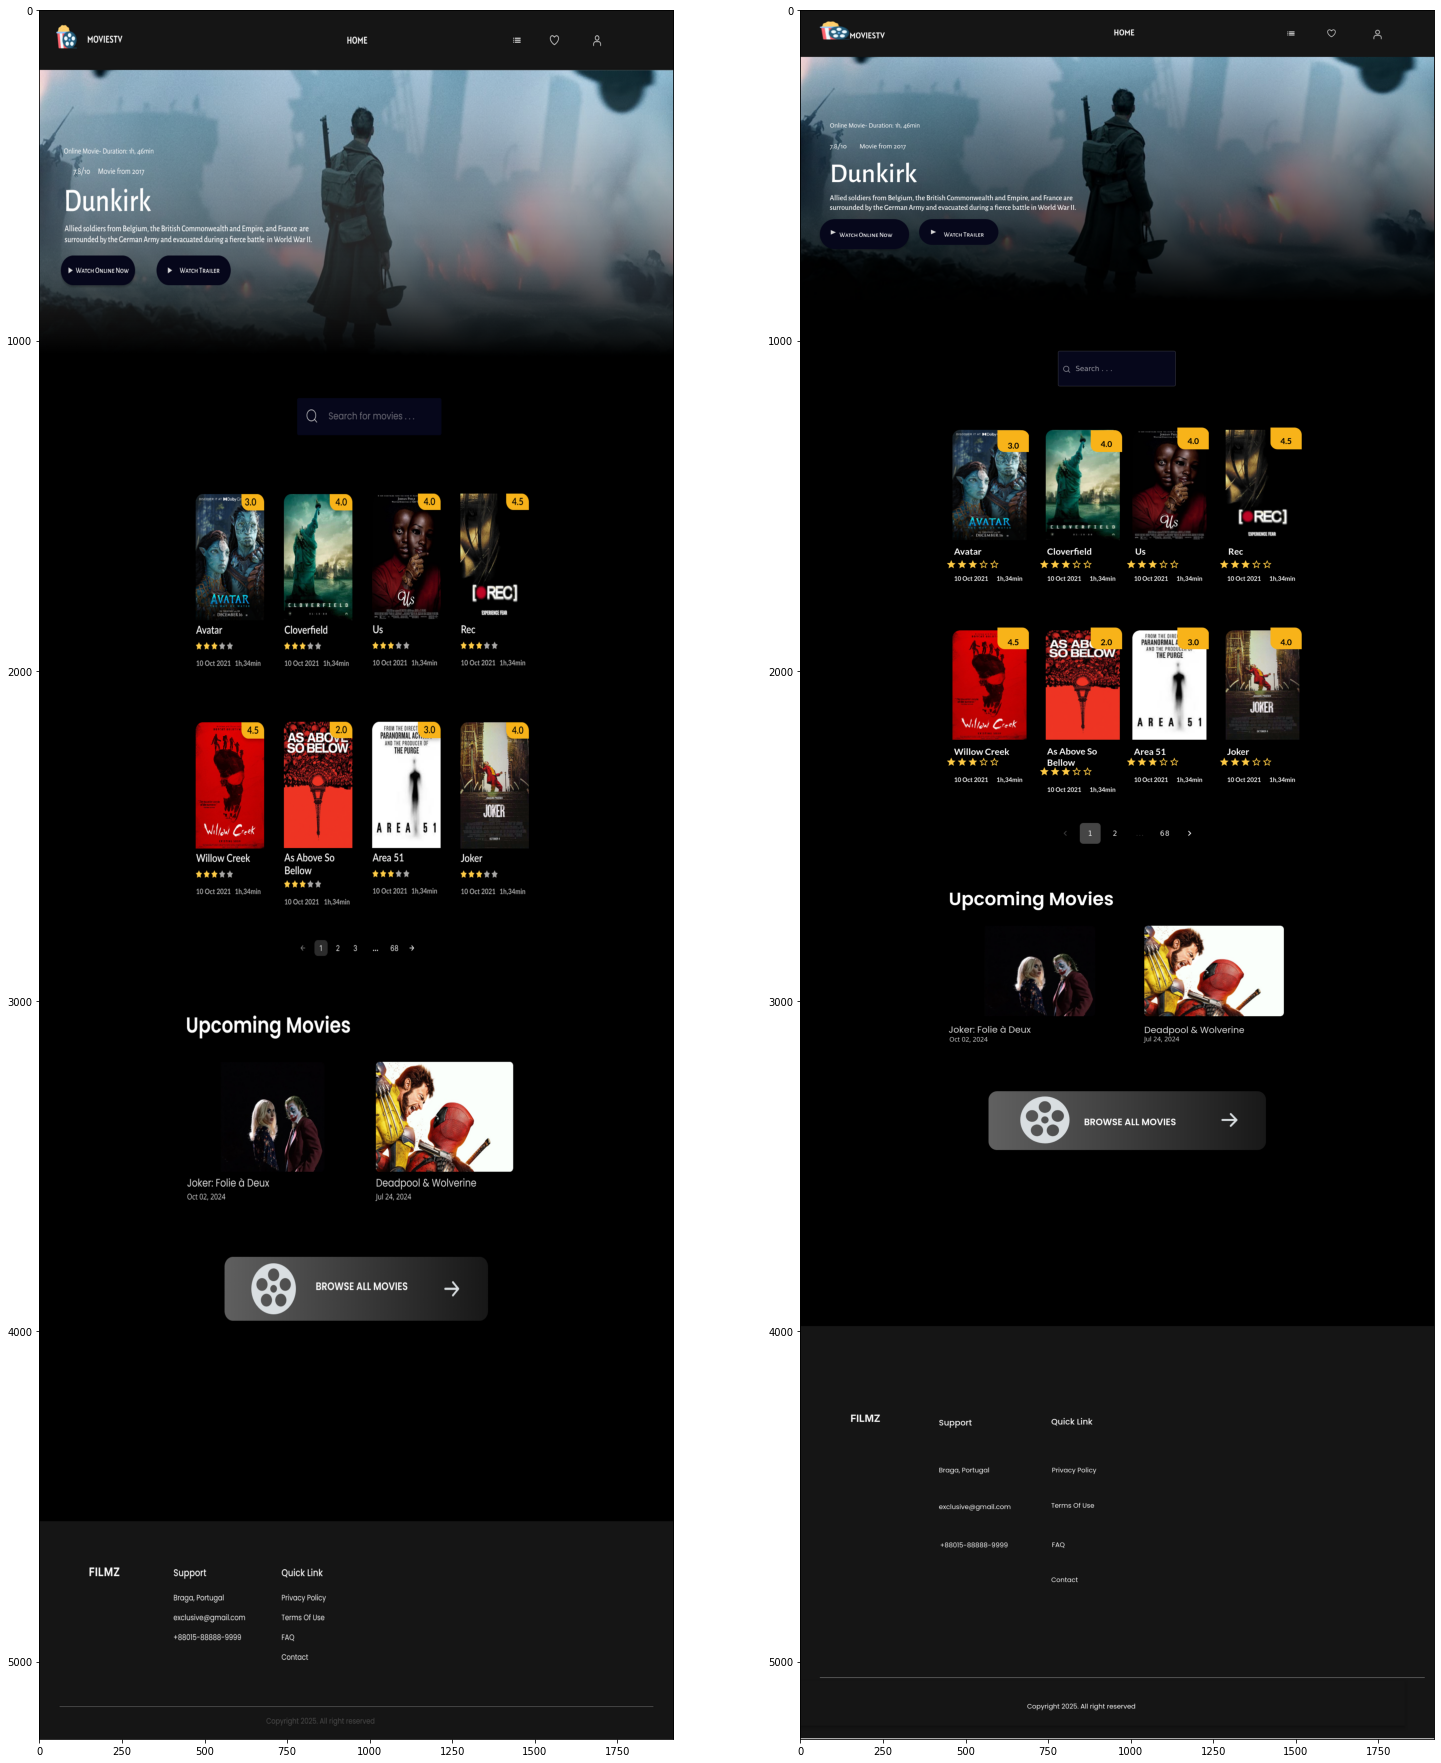

In [3]:
nr_grows = len(generatedFiles)
nr_prows = len(prototypeFiles)

dim=0
if(nr_grows==1): dim=1
fig, ax = plt.subplots(ncols=2,nrows=nr_grows,figsize=(25,50))
img_sizes = []


for x in range(0,nr_prows):
    img = Image.open(prototypeFiles[x])
    ix,iy = (Image.open(prototypeFiles[x]).size[0],Image.open(prototypeFiles[x]).size[1])
    img_sizes.append((ix,iy))
    if(dim==1):
        ax[0].imshow(img)
    else: ax[x,0].imshow(img)
    
for y in range(0,nr_grows):
    img = Image.open(generatedFiles[y])
    img_resized = img.resize((img_sizes[y][0], img_sizes[y][1]))
    img_resized.save(generatedFiles[y])
    img = plt.imread(generatedFiles[y])
    if(dim==1):
        ax[1].imshow(img)
    else: ax[y,1].imshow(img)
    

    
plt.show()

### Evalute the cosine similarity using a convolutional neural network (RestNet model)

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

In [5]:
# Already pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [6]:
# Print model layers
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} — {layer.output_shape}")

0: input_1 — [(None, None, None, 3)]
1: conv1_pad — (None, None, None, 3)
2: conv1_conv — (None, None, None, 64)
3: conv1_bn — (None, None, None, 64)
4: conv1_relu — (None, None, None, 64)
5: pool1_pad — (None, None, None, 64)
6: pool1_pool — (None, None, None, 64)
7: conv2_block1_1_conv — (None, None, None, 64)
8: conv2_block1_1_bn — (None, None, None, 64)
9: conv2_block1_1_relu — (None, None, None, 64)
10: conv2_block1_2_conv — (None, None, None, 64)
11: conv2_block1_2_bn — (None, None, None, 64)
12: conv2_block1_2_relu — (None, None, None, 64)
13: conv2_block1_0_conv — (None, None, None, 256)
14: conv2_block1_3_conv — (None, None, None, 256)
15: conv2_block1_0_bn — (None, None, None, 256)
16: conv2_block1_3_bn — (None, None, None, 256)
17: conv2_block1_add — (None, None, None, 256)
18: conv2_block1_out — (None, None, None, 256)
19: conv2_block2_1_conv — (None, None, None, 64)
20: conv2_block2_1_bn — (None, None, None, 64)
21: conv2_block2_1_relu — (None, None, None, 64)
22: conv2_bl

In [7]:
#Preprocessing function for the images
def loadImage_batchPreprocessing(paths):
    imgs = []
    for path in paths:
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        imgs.append(img_array)
    imgs = np.array(imgs)
    return preprocess_input(imgs)

In [8]:
#Extract embeddings in batches
def get_embeddings(paths):
    batch = loadImage_batchPreprocessing(paths)
    embeddings = base_model(batch)
    embeddings = tf.nn.l2_normalize(embeddings, axis=1)
    return embeddings.numpy()

In [9]:
#Compute cosine similarity for pairs of embeddings (one-to-one pairs)
def batch_cosine_similarity(embeddings1, embeddings2):
    # embeddings1 and embeddings2 shape: (batch_size, embedding_dim)
    similarities = np.sum(embeddings1 * embeddings2, axis=1)  # element-wise dot product
    return similarities

In [10]:
# Get embeddings for both batches
proto_embeddings = get_embeddings(prototypeFiles)
webui_embeddings = get_embeddings(generatedFiles)

In [11]:
# Compute similarity for each pair
similarity_scores = batch_cosine_similarity(proto_embeddings, webui_embeddings)

In [12]:
for i, score in enumerate(similarity_scores):
    print(f"Pair {i} similarity: {score:.4f}")

Pair 0 similarity: 0.9293


In [13]:
# Some intermediate layers
layer_names = [
    'conv1_relu', 
    'conv2_block3_out',   
    'conv3_block4_out'
]
from tensorflow.keras.models import Model
# Model that outputs the intermediate layers
intermediate_layer_model = Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(name).output for name in layer_names]
)


In [14]:
# Get intermediate feature maps
def get_intermediate_features(paths):
    x = loadImage_batchPreprocessing(paths)
    return intermediate_layer_model.predict(x)

In [15]:
def show_layer_differences_batch(proto_feats, webui_feats, layer_names):
    num_pairs = proto_feats[0].shape[0]
    indices = range(num_pairs)
    
    for i in indices:
        print(f"Heatmap of Pair {i}:")
        for l, (layer_name, proto_f, web_f) in enumerate(zip(layer_names, proto_feats, webui_feats)):
            # Take difference and sum across channels to get 2D heatmap
            diff = np.abs(proto_f[i] - web_f[i])
            heatmap = np.sum(diff, axis=-1)

            plt.figure(figsize=(5, 4))
            plt.imshow(heatmap, cmap='hot')
            plt.title(f'Layer {layer_name} – Pair {i}')
            plt.axis('off')
            plt.show()

1/1 [==============================] - 0s 279ms/step
Heatmap of Pair 0:


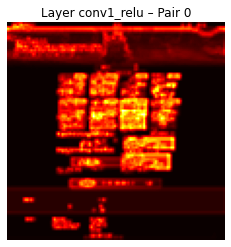

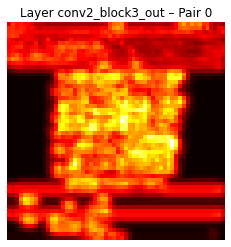

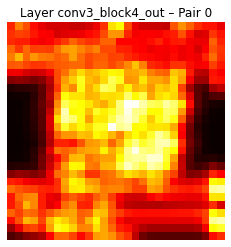

In [16]:
proto_features = get_intermediate_features(prototypeFiles)
webui_features = get_intermediate_features(generatedFiles)

show_layer_differences_batch(proto_features, webui_features, layer_names)

In [17]:
# Average similarity in all pairs
n = len(list(enumerate(similarity_scores)))
avr = sum(similarity_scores)/ n
print(f"Average similarity: {str(avr)}%")

Average similarity: 0.9292923212051392%


### Calculate structural similarity index measure (SSIM) between the pairs

In [18]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np

In [19]:
def image2GrayScale(img):
    image = cv2.imread(img)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [43]:
def getSimilarity(pair,proto,webui):
    proto_gray = image2GrayScale(proto)
    webui_gray = image2GrayScale(webui)
    # Compute SSIM between two images
    (score, diff) = structural_similarity(proto_gray, webui_gray, full=True)
    print(f"Image similarity for pair {str(pair)}: {str(round(score*100,2))} %")
    return score, diff

In [33]:
def getdiff_regions(diff):
    diff = (diff * 255).astype("uint8")
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    return contours

In [34]:
import os
path = '/home/joao/figma2vuejs/evaluation/diff'

def safe_imwrite(name, img):
    if img.dtype != np.uint8:
        img = (img * 255).astype("uint8")
    success = cv2.imwrite(name, img)
    if not success:
        print("Failed to save:", name)

In [46]:
def show_regions(contours,diff,img1,img2):
    name1 = img1.split("/")[len(img1.split("/"))-1]
    name2 = img2.split("/")[len(img2.split("/"))-1]
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    mask = np.zeros(img1.shape, dtype='uint8')
    filled_after = img2.copy()

    for c in contours:
        area = cv2.contourArea(c)
        if area > 40:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img1, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.rectangle(img2, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.drawContours(mask, [c], 0, (0,255,0), -1)
            cv2.drawContours(filled_after, [c], 0, (0,255,0), -1)

    safe_imwrite(os.path.join(path,"before-"+name2), img1)
    safe_imwrite(os.path.join(path,"after-"+name2), img2)
    safe_imwrite(os.path.join(path,"diff-"+name2), diff)
    safe_imwrite(os.path.join(path,"mask-"+name2), mask)
    safe_imwrite(os.path.join(path,"filled_after-"+name2), filled_after)
    cv2.waitKey(0)

In [53]:
for i in range(0,len(prototypeFiles)):
    if(i<len(generatedFiles)):
        score,diff = getSimilarity(i,prototypeFiles[i],generatedFiles[i])
        contours = getdiff_regions(diff)
        show_regions(contours,diff,prototypeFiles[i],generatedFiles[i])

Image similarity for pair 0: 60.85 %


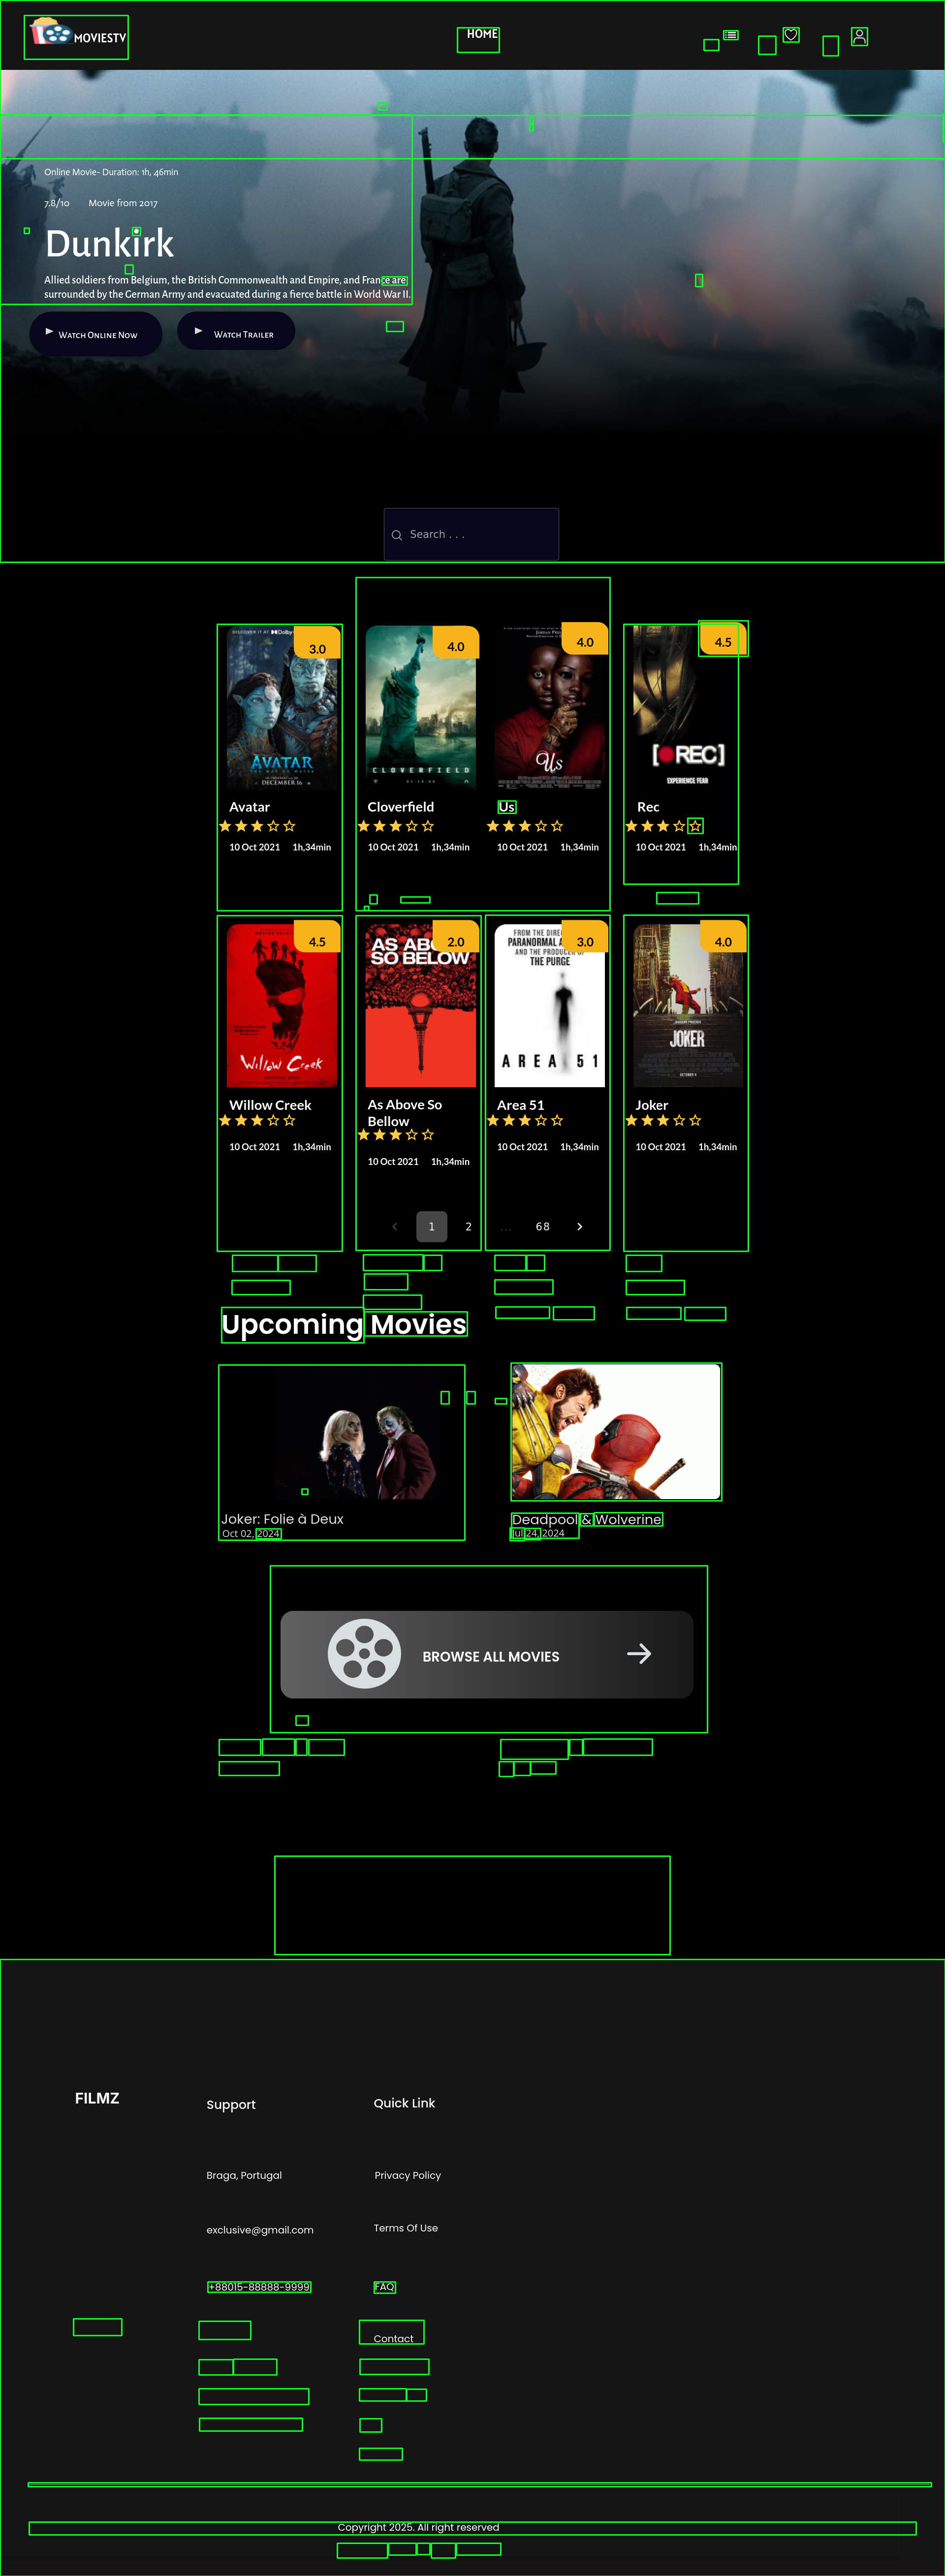

In [66]:
from IPython.display import Image, display
import random
diffdir = "/home/joao/figma2vuejs/evaluation/diff/"

aftercapture_files = [diffdir+f for f in listdir(diffdir) if isfile(join(diffdir, f)) and "/after-capture" in diffdir+f]
if(len(aftercapture_files)>3):
    aftercapture_files = random.sample(aftercapture_files, 3)

for img in aftercapture_files:
    display(Image(filename = img, width = 600, height = 300))